In [1]:
import numpy as np

from nbodykit.source.catalog import Gadget1Catalog, BigFileCatalog
from nbodykit.lab import FOF
from nbodykit.cosmology import Cosmology

### Load DM catalog & Find Halos

In [3]:
MYPlanck = Cosmology(m_ncdm=[],
               Omega0_b=0.0491,
               Omega0_cdm=0.3156 - 0.0491, 
               h=0.6727)\
            .match(sigma8=0.831)

In [3]:
def Gadget2BigFile(fname):
    cat = Gadget1Catalog(fname, ptype=1, 
                         columndefs=[('Position', ('auto', 3), 'all'), 
                                     ('GadgetVelocity', ('auto', 3), 'all'), 
                                     ('ID', 'auto', 'all')])

    attrs = cat.attrs.copy()
    cat.attrs.clear()

    cat.attrs['MassTable'] = attrs['Massarr']
    cat.attrs['TotNumPart'] = np.int64(attrs['Nall']) + (np.int64(attrs['NallHW']) << 32)
    cat.attrs['TotNumPartInit'] = np.int64(attrs['Nall']) + (np.int64(attrs['NallHW']) << 32)
    cat.attrs['BoxSize'] = attrs['BoxSize']*np.ones(3) # for FOF finder
    cat.attrs['Time'] = attrs['Time']
    cat.attrs['ScalingFactor'] = attrs['Time']

    cat.attrs['TimeIC'] = attrs['Time']

    cat.attrs['UnitVelocity_in_cm_per_s'] = 1e5

    cat.attrs['UnitLength_in_cm'] = 3.085678e21

    cat.attrs['UnitMass_in_g'] = 1.989e43

    # The velocity convention is weird without this
    cat.attrs['UsePeculiarVelocity'] = True

    a = attrs['Time']
    cat['Velocity'] = cat['GadgetVelocity'] * a ** 0.5

    return cat

Nbody simulation, FOF with linking-length=0.200

In [2]:
halos_nbd = BigFileCatalog("../catalog/Nbody/", dataset="LL-0.200/", header='Header')

/home/suqikuai777/.local/lib/python3.10/site-packages/bigfile/__init__.py:358: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  return pyxbigfile.Dataset.__init__(self, file, dtype=dtype, size=size)


FastPM with Nbody IC, FOF with linking-length=0.200

In [3]:
halos_fpm_nbdic = BigFileCatalog("../catalog/calibration/jiajun/N256/a_0.7692/", dataset="LL-0.200/", header="Header")

FastPM N512 with Nbody IC, FOF with linking-length=0.200

In [4]:
halos_fpm_nbdic_n512 = BigFileCatalog("../catalog/calibration/jiajun/N512/a_0.7692/", dataset="LL-0.200/", header="Header")

FastPM with random IC, FOF with linking-length=0.200

In [7]:
halos_fpm_ranic = BigFileCatalog("../catalog/calibration/randomIC/a_0.7692/", dataset="LL-0.200/", header="Header")

### Calculate (cumulative) Halo Mass Function

In [5]:
from WLutil.measure import get_abundance
from WLutil.visualize import simple_plot, residual_plot

Theoretical calculation

In [6]:
from colossus.cosmology import cosmology
from colossus.lss import mass_function

Define Mass Bin

In [7]:
bins = np.linspace(10, 15.5, 50)

In [8]:
def cal_binned_HMF(mass, z, islog=True, mdef='fof', model='watson13', ifcum=True):
    params = {'flat': True, 'H0': 67.27, 'Om0': 0.3156, 'Ob0': 0.0491, 'sigma8': 0.831, 'ns': 1.0}
    cosmology.addCosmology('myCosmo', **params)
    cosmology.setCosmology('myCosmo')

    if not islog:
        mass = np.log10(mass)
    if len(mass) != 1:
        ledge = mass[0] - (mass[1]-mass[0])/2.
        redge = mass[-1] + (mass[-1]-mass[-2])/2.
        edges = np.append(ledge, np.append((mass[1:]+mass[:-1])/2., redge))
    
        binned_mfunc = []
        for i in range(len(edges)-1):
            Mmin = edges[i]
            Mmax = edges[i+1]
            Minte = np.linspace(Mmin, Mmax, 100)
            mfunc_fof = mass_function.massFunction(10**Minte, z, mdef=mdef, model=model, q_out='dndlnM')
            binned_mfunc.append(np.trapz(mfunc_fof, np.log(10.)*Minte))
    else:
        binned_mfunc = [mass_function.massFunction(10**mass, z, mdef=mdef, model=model, q_out='dndlnM')]
    
    if ifcum:
        return (np.cumsum(binned_mfunc[::-1])[::-1])
    else:
        return (np.array(binned_mfunc))

In [9]:
redshift = 0.3
boxsize = 400
Om0 = 0.31
params = {'flat': True, 'H0': 67.27, 'Om0': 0.3156, 'Ob0': 0.0491, 'sigma8': 0.831, 'ns': 1.0}
cosmology.addCosmology('myCosmo', **params)
cosmology.setCosmology('myCosmo');

# binned_mfun_fof = cal_binned_HMF(bins, z=0.3, islog=True, mdef='fof', model='watson13')
logNm_watson13 = cal_binned_HMF(bins, z=0.3, islog=True, mdef='fof', model='watson13', ifcum=False)

Measure HMF from halo catalog

In [10]:
def get_HMF(mass, bins, boxsize, isedge=False, bin_scale='linear', ifcum=True):
    mctr_list = []
    logNm_list = []

    if type(mass) is not list:
        mass = [mass]
    if type(boxsize) is not list:
        boxsize = [boxsize]*len(mass)
    elif len(boxsize) != len(mass):
        raise ValueError("The size of boxsize list must be the same as mass list!")
    
    for imass, ibox in zip(mass, boxsize):
        ni, mi = get_abundance(imass, bins, isedge=isedge, bin_scale=bin_scale, density=False)
        if bin_scale == 'linear':
            mctr = (mi[1:] + mi[:-1])/2.
        else:
            mctr = np.sqrt(mi[1:]*mi[:-1])
        if ifcum:
            ilogNm = (np.cumsum(ni[::-1])[::-1]/ibox/ibox/ibox)
        else:
            ilogNm = (ni/ibox/ibox/ibox)

        mctr_list.append(mctr)
        logNm_list.append(ilogNm)

    if len(mctr_list) == 1:
        return mctr_list[0], logNm_list[0]
    else:
        return mctr_list, logNm_list

In [11]:
mass_list = [np.log10(halos_nbd['Mass'].compute()),
            np.log10(halos_fpm_nbdic['Mass'].compute()),
            # np.log10(halos_fpm_ranic['Mass'].compute()), 
            np.log10(halos_fpm_nbdic_n512['Mass'].compute())]
mctr_list, logNm_list = get_HMF(mass_list, bins, boxsize=400.0, ifcum=False)

/home/suqikuai777/.local/lib/python3.10/site-packages/bigfile/__init__.py:358: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  return pyxbigfile.Dataset.__init__(self, file, dtype=dtype, size=size)


choose the Maximum halos that match nh of BOSS, and measure wp, should be larger than BOSS's results.
mass times gaussian random with sigma~0.2-0.3 like SHAM (HAM) should be smaller than first results.

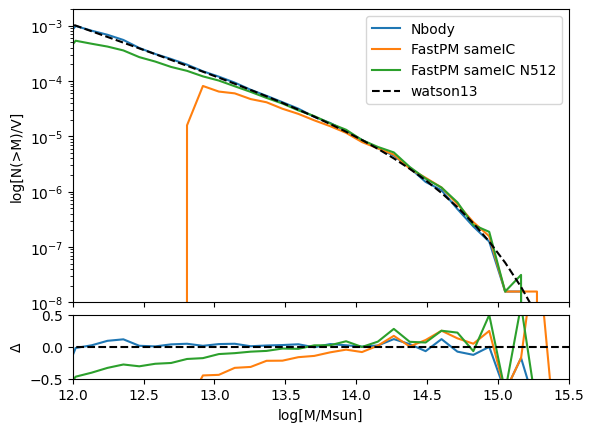

In [14]:
residual_plot(mctr_list+[bins], logNm_list+[logNm_watson13],
            clist=[None]*len(logNm_list)+['k'],
            lslist=['-']*len(logNm_list)+['--'], 
            legends=['Nbody', 
                     'FastPM sameIC', 
                    #  'FastPM randomIC',
                     'FastPM sameIC N512',
                     'watson13'], 
            scale='semilogy',
            xlim=[12, 15.5], y1lim=[1e-8, 2*10**(-3)], y2lim=[-0.5,0.5],
            xlabel='log[M/Msun]', y1label='log[N(>M)/V]', y2label=r'$\Delta$');

In [16]:
np.sum((halos_fpm_nbdic_n512['Mass']>10**(13.5)).compute())

/home/suqikuai777/.local/lib/python3.10/site-packages/bigfile/__init__.py:358: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  return pyxbigfile.Dataset.__init__(self, file, dtype=dtype, size=size)
/home/suqikuai777/.local/lib/python3.10/site-packages/bigfile/__init__.py:358: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  return pyxbigfile.Dataset.__init__(self, file, dtype=dtype, size=size)


7807

In [62]:
np.sum((halos_nbd['Mass']>10**(14)).compute())

/home/suqikuai777/.local/lib/python3.10/site-packages/bigfile/__init__.py:358: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  return pyxbigfile.Dataset.__init__(self, file, dtype=dtype, size=size)


1521

### Measure halo 2pcf

In [37]:
from WLutil.measure import get_auto_2pcf

halo mass > 1e13

In [57]:
cut = halos_nbd['Mass'].compute()>1e13
r, mono, quad, hexi = get_auto_2pcf((halos_nbd['Position'][cut]/1000).compute(), boxsize=400., min_sep=0.5, max_sep=150, nbins=20, scale='linear')

/home/suqikuai777/.local/lib/python3.10/site-packages/bigfile/__init__.py:358: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  return pyxbigfile.Dataset.__init__(self, file, dtype=dtype, size=size)


Loading configurations ...
  CONFIG_FILE     = fcfc_2pt_box.conf
  CATALOG_LABEL   = 'D' , 'R'
  BOX_SIZE        = 400 , 400 , 400
  DATA_STRUCT     = 0 (k-d tree)
  BINNING_SCHEME  = 1 (s & mu)
  PAIR_COUNT      = DD , DR , RR
  CF_ESTIMATOR    = (DD - 2*DR + RR)/RR
  MULTIPOLE       = 0 , 2 , 4
  OMP_NUM_THREADS = 32
[DONE]
Initializing the correlation function calculator ...
  19 separation bins loaded

Creating a hybrid lookup table for nonlinear bins
  Separation bins initialized successfully
  Memory allocated for pair counts and correlation functions
[DONE]
Construct the tree for catalog 'D' ...
  k-d tree (4095 nodes) constructed for the catalog
[DONE]
Counting DD pairs ...
[DONE]
Construct the tree for catalog 'R' ...
  k-d tree (65535 nodes) constructed for the catalog
[DONE]
Counting DR pairs ...
[DONE]
Counting RR pairs ...
[DONE]
Evaluate correlation function estimators ...
[DONE]
Compute correlation function multipoles ...
[DONE]


In [70]:
cut = halos_nbd['Mass'].compute()>10**(13)
np.sum(cut)

29328

In [59]:
cut = halos_fpm_nbdic['Mass'].compute()>1e13
r_ic, mono_ic, quad, hexi = get_auto_2pcf(halos_fpm_nbdic['Position'].compute()[cut], boxsize=400., min_sep=0.5, max_sep=150, nbins=20, scale='linear')

/home/suqikuai777/.local/lib/python3.10/site-packages/bigfile/__init__.py:358: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  return pyxbigfile.Dataset.__init__(self, file, dtype=dtype, size=size)



Loading configurations ...
  CONFIG_FILE     = fcfc_2pt_box.conf
  CATALOG_LABEL   = 'D' , 'R'
  BOX_SIZE        = 400 , 400 , 400
  DATA_STRUCT     = 0 (k-d tree)
  BINNING_SCHEME  = 1 (s & mu)
  PAIR_COUNT      = DD , DR , RR
  CF_ESTIMATOR    = (DD - 2*DR + RR)/RR
  MULTIPOLE       = 0 , 2 , 4
  OMP_NUM_THREADS = 32
[DONE]
Initializing the correlation function calculator ...
  19 separation bins loaded

Creating a hybrid lookup table for nonlinear bins
  Separation bins initialized successfully
  Memory allocated for pair counts and correlation functions
[DONE]
Construct the tree for catalog 'D' ...
  k-d tree (4095 nodes) constructed for the catalog
[DONE]
Counting DD pairs ...
[DONE]
Construct the tree for catalog 'R' ...
  k-d tree (32767 nodes) constructed for the catalog
[DONE]
Counting DR pairs ...
[DONE]
Counting RR pairs ...
[DONE]
Evaluate correlation function estimators ...
[DONE]
Compute correlation function multipoles ...
[DONE]


In [71]:
cut = halos_fpm_nbdic['Mass'].compute()>10**(13)
np.sum(cut)

21272

In [55]:
cut = halos_fpm['Mass'].compute()>1e13
r2, mono2, quad, hexi = get_auto_2pcf(halos_fpm['Position'].compute()[cut], boxsize=400., min_sep=0.5, max_sep=150, nbins=20, scale='linear')

/home/suqikuai777/.local/lib/python3.10/site-packages/bigfile/__init__.py:358: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  return pyxbigfile.Dataset.__init__(self, file, dtype=dtype, size=size)



Loading configurations ...
  CONFIG_FILE     = fcfc_2pt_box.conf
  CATALOG_LABEL   = 'D' , 'R'
  BOX_SIZE        = 400 , 400 , 400
  DATA_STRUCT     = 0 (k-d tree)
  BINNING_SCHEME  = 1 (s & mu)
  PAIR_COUNT      = DD , DR , RR
  CF_ESTIMATOR    = (DD - 2*DR + RR)/RR
  MULTIPOLE       = 0 , 2 , 4
  OMP_NUM_THREADS = 32
[DONE]
Initializing the correlation function calculator ...
  19 separation bins loaded

Creating a hybrid lookup table for nonlinear bins
  Separation bins initialized successfully
  Memory allocated for pair counts and correlation functions
[DONE]
Construct the tree for catalog 'D' ...
  k-d tree (4095 nodes) constructed for the catalog
[DONE]
Counting DD pairs ...
[DONE]
Construct the tree for catalog 'R' ...
  k-d tree (32767 nodes) constructed for the catalog
[DONE]
Counting DR pairs ...
[DONE]
Counting RR pairs ...
[DONE]
Evaluate correlation function estimators ...
[DONE]
Compute correlation function multipoles ...
[DONE]


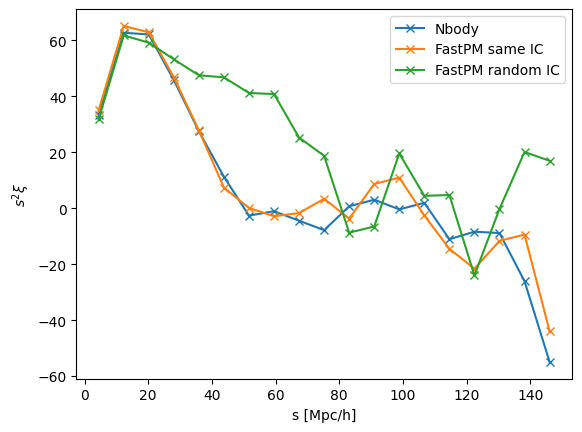

In [60]:
simple_plot([r, r_ic, r2], [mono*r**2, mono_ic*r_ic**2, mono2*r2**2], scale='linear', 
            mlist='x', xlabel="s [Mpc/h]", ylabel=r"$s^2\xi$", 
            legends=['Nbody', 'FastPM same IC', 'FastPM random IC']);

In [96]:
len(halos_fpm_nbdic['Position'][cut])

21272

### Measure Void statistics

Void Size Function

In [11]:
import numpy as np
from nbodykit.source.catalog import BigFileCatalog
from WLutil.catalog import DMpart, Tracer
from WLutil.measure import get_abundance
from WLutil.visualize import hist_plot, simple_plot, residual_plot

In [15]:
void_nbd = Tracer()
void_nbd.load_from_ascii("../catalog/Nbody/Void_cut.dat", Radius=-1)

In [16]:
void_fpm_nbdic = Tracer()
void_fpm_nbdic.load_from_ascii("../catalog/calibration/jiajun/a_0.7692/Void_cut.dat", Radius=-1)

raw Radius bin

In [17]:
raw_Rbins = np.linspace(0, 30, 16)
raw_Rbins

array([ 0.,  2.,  4.,  6.,  8., 10., 12., 14., 16., 18., 20., 22., 24.,
       26., 28., 30.])

In [18]:
n1, R1 = get_abundance(void_nbd.Radius, bins=raw_Rbins, isedge=True, density=True)
n2, R2 = get_abundance(void_fpm_nbdic.Radius, bins=raw_Rbins, isedge=True, density=True)

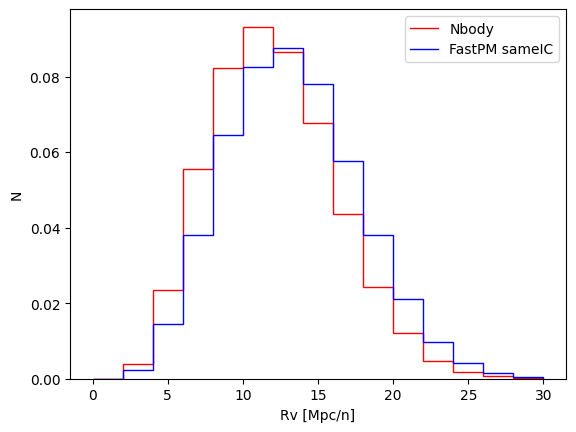

In [19]:
hist_plot([n1, n2], [R1, R2], clist=['r', 'b'], legends=['Nbody', 'FastPM sameIC'],
          xlabel='Rv [Mpc/n]', ylabel='N');

rescaled Radius bin

In [20]:
re_Rbins = np.linspace(0, 2.5, 20)
re_Rbins

array([0.        , 0.13157895, 0.26315789, 0.39473684, 0.52631579,
       0.65789474, 0.78947368, 0.92105263, 1.05263158, 1.18421053,
       1.31578947, 1.44736842, 1.57894737, 1.71052632, 1.84210526,
       1.97368421, 2.10526316, 2.23684211, 2.36842105, 2.5       ])

In [21]:
tmp = BigFileCatalog("../catalog/Nbody/", dataset="LL-0.200/")
cut = tmp['Mass'].compute()>1e13
nh_nbd = len(tmp['Position'][cut])/400./400./400.

tmp = BigFileCatalog("../catalog/calibration/jiajun/a_0.7692/", dataset="LL-0.200/")
cut = tmp['Mass'].compute()>1e13
nh_fpm_nbdic = len(tmp['Position'][cut])/400./400./400.

/home/suqikuai777/.local/lib/python3.10/site-packages/bigfile/__init__.py:358: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  return pyxbigfile.Dataset.__init__(self, file, dtype=dtype, size=size)


In [22]:
n1, R1 = get_abundance(void_nbd.Radius*nh_nbd**(1./3.), bins=re_Rbins, isedge=True, density=True)
n2, R2 = get_abundance(void_fpm_nbdic.Radius*nh_fpm_nbdic**(1./3.), bins=re_Rbins, isedge=True, density=True)

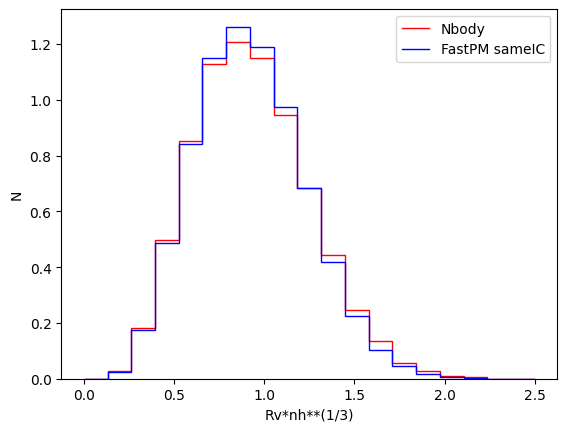

In [23]:
hist_plot([n1, n2], [R1, R2], clist=['r', 'b'], legends=['Nbody', 'FastPM sameIC'],
          xlabel='Rv*nh**(1/3)', ylabel='N');

In [10]:
from scipy.stats import ks_2samp

In [11]:
ks_2samp(void_nbd.Radius*nh_nbd**(1./3.), void_fpm_nbdic.Radius*nh_fpm_nbdic**(1./3.))

KstestResult(statistic=0.016234650396732553, pvalue=1.6387602516638027e-19, statistic_location=1.1332990771682332, statistic_sign=-1)

Void profile

In [51]:
from WLutil.measure import get_cross_2pcf

In [31]:
reRmin = 1.2
reRmax = 1.3
reRv = (reRmin + reRmax)/2.

In [30]:
cut = (reRmin < void_nbd.Radius*nh_nbd**(1./3.)) & (void_nbd.Radius*nh_nbd**(1./3.) < reRmax)
void_nbd_pos = void_nbd.pos[cut]
Rv_nbd = reRv/(nh_nbd**(1./3.))
Rv_nbd

16.213465625040612

In [75]:
dm_nbd = Tracer()
dm_nbd.load_from_gadget("/mnt/d/Simu/lcdm/0/result/snapshot_011")

In [81]:
r, xi = get_cross_2pcf(dm_nbd.pos, void_nbd_pos, boxsize=400.,
                       min_sep=0.1*Rv_nbd, max_sep=10*Rv_nbd, nbins=99, scale='log')

Loading configurations ...
  CONFIG_FILE     = fcfc_2pt_box.conf
  CATALOG_LABEL   = 'A' , 'B'
  BOX_SIZE        = 400 , 400 , 400
  DATA_STRUCT     = 0 (k-d tree)
  BINNING_SCHEME  = 1 (s & mu)
  PAIR_COUNT      = AB
  CF_ESTIMATOR    = AB / @@ - 1
  MULTIPOLE       = 0
  OMP_NUM_THREADS = 32
[DONE]
Initializing the correlation function calculator ...
  98 separation bins loaded

Creating a hybrid lookup table for nonlinear bins
  Separation bins initialized successfully
  Memory allocated for pair counts and correlation functions
[DONE]
Construct the tree for catalog 'A' ...
  k-d tree (16777215 nodes) constructed for the catalog
[DONE]
Construct the tree for catalog 'B' ...
  k-d tree (8191 nodes) constructed for the catalog
[DONE]
Counting AB pairs ...
[DONE]
Evaluate correlation function estimators ...
[DONE]
Compute correlation function multipoles ...
[DONE]


In [82]:
np.savetxt("../catalog/Nbody/void_reR{:.1f}_{:.1f}.prof".format(reRmin, reRmax), np.c_[r,xi])

In [32]:
cut = (reRmin < void_fpm_nbdic.Radius*nh_nbd**(1./3.)) & (void_fpm_nbdic.Radius*nh_nbd**(1./3.) <reRmax)
void_fpm_nbdic_pos = void_fpm_nbdic.pos[cut]
Rv_fpm_nbdic = reRv/(nh_fpm_nbdic**(1./3.))

In [85]:
dm_fpm_nbdic = DMpart()
dm_fpm_nbdic.load_from_bigfile("../catalog/calibration/jiajun/a_0.7692/", dataset="1/", header="Header")

/home/suqikuai777/.local/lib/python3.10/site-packages/bigfile/__init__.py:358: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  return pyxbigfile.Dataset.__init__(self, file, dtype=dtype, size=size)


In [86]:
r2, xi2 = get_cross_2pcf(dm_fpm_nbdic.pos, void_fpm_nbdic_pos, boxsize=400.,
                       min_sep=0.1*Rv_fpm_nbdic, max_sep=10*Rv_fpm_nbdic, nbins=99, scale='log')

Loading configurations ...
  CONFIG_FILE     = fcfc_2pt_box.conf
  CATALOG_LABEL   = 'A' , 'B'
  BOX_SIZE        = 400 , 400 , 400
  DATA_STRUCT     = 0 (k-d tree)
  BINNING_SCHEME  = 1 (s & mu)
  PAIR_COUNT      = AB
  CF_ESTIMATOR    = AB / @@ - 1
  MULTIPOLE       = 0
  OMP_NUM_THREADS = 32
[DONE]
Initializing the correlation function calculator ...
  98 separation bins loaded

Creating a hybrid lookup table for nonlinear bins
  Separation bins initialized successfully
  Memory allocated for pair counts and correlation functions
[DONE]
Construct the tree for catalog 'A' ...
  k-d tree (2097151 nodes) constructed for the catalog
[DONE]
Construct the tree for catalog 'B' ...
  k-d tree (4095 nodes) constructed for the catalog
[DONE]
Counting AB pairs ...
[DONE]
Evaluate correlation function estimators ...
[DONE]
Compute correlation function multipoles ...
[DONE]


In [57]:
np.savetxt("../catalog/calibration/jiajun/a_0.7692/void_reR{:.1f}_{:.1f}.prof".format(reRmin, reRmax), np.c_[r2,xi2])

show void profile

In [33]:
tmp = np.loadtxt("../catalog/Nbody/void_reR{:.1f}_{:.1f}.prof".format(reRmin, reRmax))
r, xi = tmp[:,0], tmp[:,1]

In [34]:
tmp = np.loadtxt("../catalog/calibration/jiajun/a_0.7692/void_reR{:.1f}_{:.1f}.prof".format(reRmin, reRmax))
r2, xi2 = tmp[:,0], tmp[:,1]

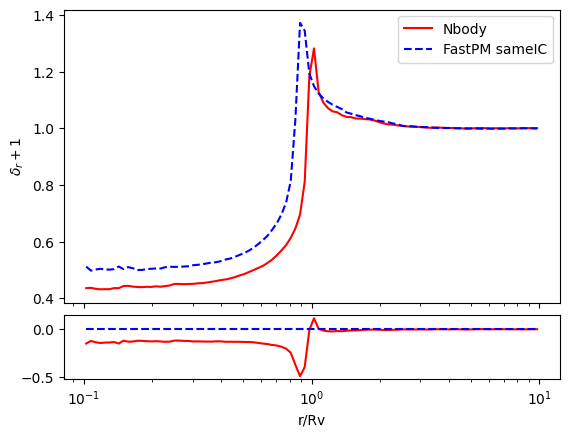

In [35]:
fig, ax1, ax2 = residual_plot([r/Rv_nbd,r2/Rv_fpm_nbdic], [xi+1, xi2+1],
                               clist=['r', 'b'], refline=1, scale='semilogx', legends=['Nbody', 'FastPM sameIC'],
                               xlabel='r/Rv', y1label=r'$\delta_r+1$', 
                                show=False);
# ax1.text(2, 0.6, "Rv_nbd = {:.2f}\nRv_fpm = {:.2f}".format(Rv_nbd, Rv_fpm_nbdic));

mean value of Rv is no good
Define the void radius as the pos of the peak
total matter? center low --> out high